In [1]:
!pip install tensorflow


  Using cached tensorboard-2.8.0-py3-none-any.whl (5.8 MB)
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2


In [6]:
import numpy as np 
import pandas as pd 
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import re
import gc
import glob
import seaborn as sns
import tensorflow as tf
from mlxtend.plotting import plot_confusion_matrix
from tensorflow import keras 
from keras.models import Sequential, Model, load_model
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.optimizers import Adam,SGD
from keras import backend as K
from tensorflow.python.framework import ops
from time import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve,roc_auc_score
from keras import regularizers
import datetime
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, Input,Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from tensorflow.nn import relu, sigmoid
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization

In [3]:
 pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [ ]:
 conda install -c conda-forge opencv

In [4]:
pip install mlxtend  

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install keras-layer-normalization

  Created wheel for keras-layer-normalization: filename=keras_layer_normalization-0.16.0-py3-none-any.whl size=4667 sha256=8f2ed9645caa3027a731019d9e5df6cb5cb227b2ca4a715979ade0a05bcbe3e6
  Stored in directory: c:\users\computing\appdata\local\pip\cache\wheels\d7\2b\f4\28f4bab995fa99c26b761bc7f9aeb5bf6c81e9be6ccd0b853b
Successfully built keras-layer-normalization
Note: you may need to restart the kernel to use updated packages.


In [8]:
train = r"C:\\Users\Computing\Downloads\data-task1\data-task1\train"
val   = r"C:\Users\Computing\Downloads\data-task1\data-task1\val"
test  = r"C:\Users\Computing\Downloads\data-task1\data-task1\test"

In [5]:
batch_size = 128
num_classes = 10
epochs = 12

In [9]:
# list has two lists inside, where the first one includes images with pneumonia and the second one includes normal images
import os
class_names = os.listdir(train)
test_image_files = [[os.path.join(test, class_name, x) 
               for x in os.listdir(os.path.join(test, class_name))] 
               for class_name in class_names]

train_image_files_first = [[os.path.join(train, class_name, x) 
               for x in os.listdir(os.path.join(train, class_name))] 
               for class_name in class_names]

train_with_pneumonia = train_image_files_first[0][:len(train_image_files_first[0]) // 2]
train_with_norm = train_image_files_first[1]
train_image_files = [train_with_pneumonia,  train_with_norm]

valid_image_files = [[os.path.join(val, class_name, x) 
               for x in os.listdir(os.path.join(val, class_name))] 
               for class_name in class_names]

In [10]:
print("Size of training set: ")
print(f"Number of images with pneumonia: {len(train_image_files_first[1])} and with no_pneomonia {len(train_image_files_first[0])}\n")

print("Size of test set: ")
print(f"Number of images with pneumonia: {len(test_image_files[1])} and with no_pneomonia {len(test_image_files[0])}\n")

print("Size of validation set: ")
print(f"Number of images with pneumonia: {len(valid_image_files[1])} and with no_pneomonia {len(valid_image_files[0])}")

Size of training set: 
Number of images with pneumonia: 642 and with no_pneomonia 2358

Size of test set: 
Number of images with pneumonia: 105 and with no_pneomonia 395

Size of validation set: 
Number of images with pneumonia: 110 and with no_pneomonia 390


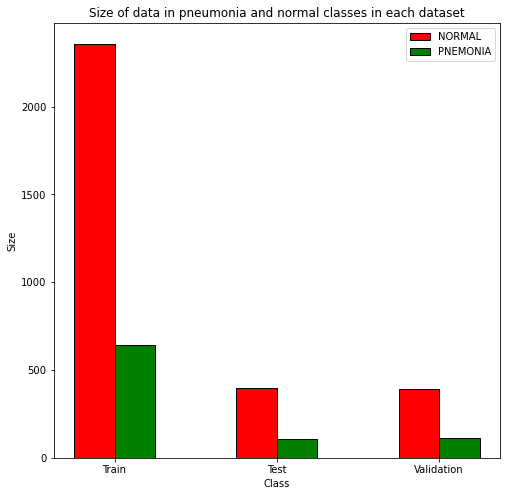

In [11]:
import numpy as np
import matplotlib.pyplot as plt
pn = [len(train_image_files_first[0]), len(test_image_files[0]), len(valid_image_files[0])]
norm = [len(train_image_files_first[1]), len(test_image_files[1]), len(valid_image_files[1])]
  
r = np.arange(3)
width = 0.25

fig = plt.figure(figsize = (8, 8))

plt.bar(r, pn, color = 'r',
        width = width, edgecolor = 'black',
        label='NORMAL')
plt.bar(r + width, norm, color = 'g',
        width = width, edgecolor = 'black',
        label='PNEMONIA')
  
plt.xlabel("Class")
plt.ylabel("Size")
plt.title("Size of data in pneumonia and normal classes in each dataset")
  
# plt.grid(linestyle='--')
plt.xticks(r + width/2, ['Train','Test','Validation'])
plt.legend()
  
plt.show()

In [12]:
def plot_performance_metrics(model):
  tr_loss = model.history['loss']
  val_loss = model.history['val_loss']
  tr_f1 = model.history['f1']
  val_f1 = model.history['val_f1']
    
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
  plt.subplots_adjust(wspace=0.40)

# Loss Plot
  ax1.plot(tr_loss)
  ax1.plot(val_loss)
  ax1.grid()
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.legend(['Train Loss', 'Test Loss'], loc='upper left')
  ax1.set_title('Plot of Train and Test Loss against Epochs')
# F1-Score Plot
  ax2.plot(tr_f1)
  ax2.plot(val_f1)
  ax2.grid()
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('F1 Score')
  ax2.legend(['Train F1-Score', 'Test F1-Score'], loc='upper left')
  ax2.set_title('Plot of Train and Test F1-Score against Epochs')
  
  plt.show()

In [25]:
#PRDICTION FUNCTION FOR SIGMOID
def predict_classes(predictions):
    valResult = predictions.copy()
    valResult[valResult <= 0.5] = 0  
    valResult[valResult > 0.5] = 1   
    return valResult

In [26]:
# Function for Confusion Matrix.
def plot_confusion_matrix(predictions, labels):
    valResult = predict_classes(predictions)    
    conf_matrix_df= pd.DataFrame(confusion_matrix(labels,valResult), index=["Normal", "Pneumonia"],columns=["Normal", "Pneumonia"])
    plt.figure(figsize=(7,6))
    plt.title("Confusion Matrix")   
    sns.heatmap(conf_matrix_df, annot=True,  annot_kws={"size" : "20"},  fmt='.4g')   
    plt.xlabel('\nPredicted',fontsize=12)    
    plt.ylabel('Actual', fontsize=12,rotation='horizontal',labelpad=40)
    
# Get TP, FP, TN and FN
    cm = confusion_matrix(labels, valResult) 
    print('='*50)                                
    print('True Positive  (TP) = ', cm[0][0])
    print('False Positive (FP) = ', cm[0][1])
    print('False Negative (FN) = ', cm[1][0])
    print('True Negative  (TN) = ', cm[1][1])
    print('-'*26)
    
# Get Precision, Recall and F1 Score

    if (cm[0][0] + cm[0][1])!=0 and (cm[0][0], cm[1][0])!=0:
      precision= round((cm[0][0] / (cm[0][0] + cm[0][1]))*100, 2) 
      recall   = round((cm[0][0] / (cm[0][0] + cm[1][0]))*100, 2) 
      f1_score = round(2*((precision*recall)/(precision+recall)), 2)       
      print(f'Precision Score: {precision}%')
      print(f'Recall Score: {recall}%')
      print(f'F1 Score: {f1_score}%')
      print('='*50) 
      print('\n')
        
# Function for ROC curve.
def plot_roc_curve(predictions, labels):
    fpr, tpr, thresholds = roc_curve(labels, predictions) 
    auc = roc_auc_score(validation_generator.classes, prediction) 
    plt.title('Receiver Operating Characteristic (ROC)  Curve',fontsize=14)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.plot(fpr, tpr, 'g',label = 'AUC Score = %0.2f' % auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('\nTrue Positive Rate (TPR)', fontsize=12)
    plt.xlabel('\nFalse Positive Rate (FPR)', fontsize=12)
    plt.legend()
    plt.grid()
    plt.show()

In [11]:
def f1(y_true, y_pred):    
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall    
    def precision(y_true, y_pred):
       
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives +  K.epsilon())
        return precision    
        precision = precision(y_true, y_pred)
        recall = recall(y_true, y_pred)
        return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [14]:
model = Sequential()
model.add(Conv2D(32, (3,3), strides=(1,1), padding='same', input_shape=(64,64,1), activation='relu'))
model.add(Conv2D(32, (3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), strides=(1,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, (3,3), strides=(1,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.60))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        3

In [15]:
gen = ImageDataGenerator()
train_batches = gen.flow_from_directory(r"C:\\Users\Computing\Downloads\data-task1\data-task1\train",model.input_shape[1:3],color_mode="grayscale",shuffle=True,seed=1,
                                        batch_size=16)
valid_batches = gen.flow_from_directory(r"C:\\Users\Computing\Downloads\data-task1\data-task1\val", model.input_shape[1:3],color_mode="grayscale", shuffle=True,seed=1,
                                        batch_size=16)
test_batches = gen.flow_from_directory(r"C:\\Users\Computing\Downloads\data-task1\data-task1\test", model.input_shape[1:3], shuffle=False,
                                       color_mode="grayscale", batch_size=8)

Found 3000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [34]:
# Tensorboard
# Load the TensorBoard notebook extension.
es = EarlyStopping(monitor='val_loss',patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)

In [37]:
model.compile(Adam(lr=0.0001, decay=1e-5),loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val)

SyntaxError: unexpected EOF while parsing (<ipython-input-37-c69fc0220342>, line 2)

In [21]:
model.save_weights("mnist-cnn-model.h5")

In [23]:
model.history

In [24]:
model.history.history


{'loss': [1.1479520797729492,
  1.1170328855514526,
  1.0142661333084106,
  0.9473724365234375,
  1.0962477922439575,
  0.9759339094161987,
  1.053708553314209,
  0.8874133229255676,
  0.8537646532058716,
  0.8661342859268188,
  0.6403243541717529,
  0.7591596841812134,
  0.7471836805343628,
  0.765017569065094,
  0.8361721038818359,
  0.7220811247825623,
  0.7012473344802856,
  0.7608045935630798,
  0.7258129119873047,
  0.7556371092796326,
  0.6372905373573303,
  0.6753848195075989,
  0.7228098511695862,
  0.6591396927833557,
  0.7104544639587402,
  0.5887749195098877,
  0.7313238978385925,
  0.6076741814613342,
  0.6488290429115295,
  0.6444281339645386,
  0.61990886926651,
  0.7378193140029907,
  0.7251048684120178,
  0.7755030989646912,
  0.6291607618331909,
  0.605255126953125,
  0.6093028783798218,
  0.6158999800682068,
  0.5714686512947083,
  0.5026214718818665,
  0.6698461771011353,
  0.5326305031776428,
  0.607879102230072,
  0.5920934081077576,
  0.5911562442779541,
  0.5005

In [18]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

ValueError: not enough values to unpack (expected 2, got 1)

In [20]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))     # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [21]:
pneumonia = os.listdir(r"C:\\Users\Computing\Downloads\data-task1\data-task1\train\pneumonia")
pneumonia_dir =r"C:\\Users\Computing\Downloads\data-task1\data-task1\train\pneumonia"

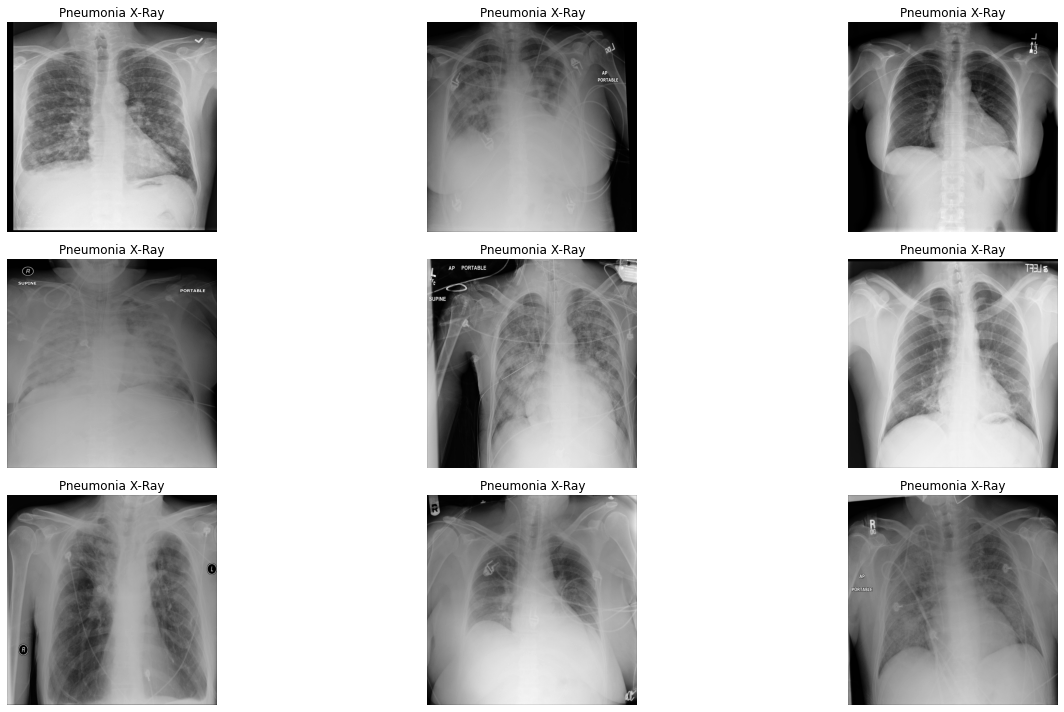

In [22]:
plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Pneumonia X-Ray") 
plt.tight_layout()

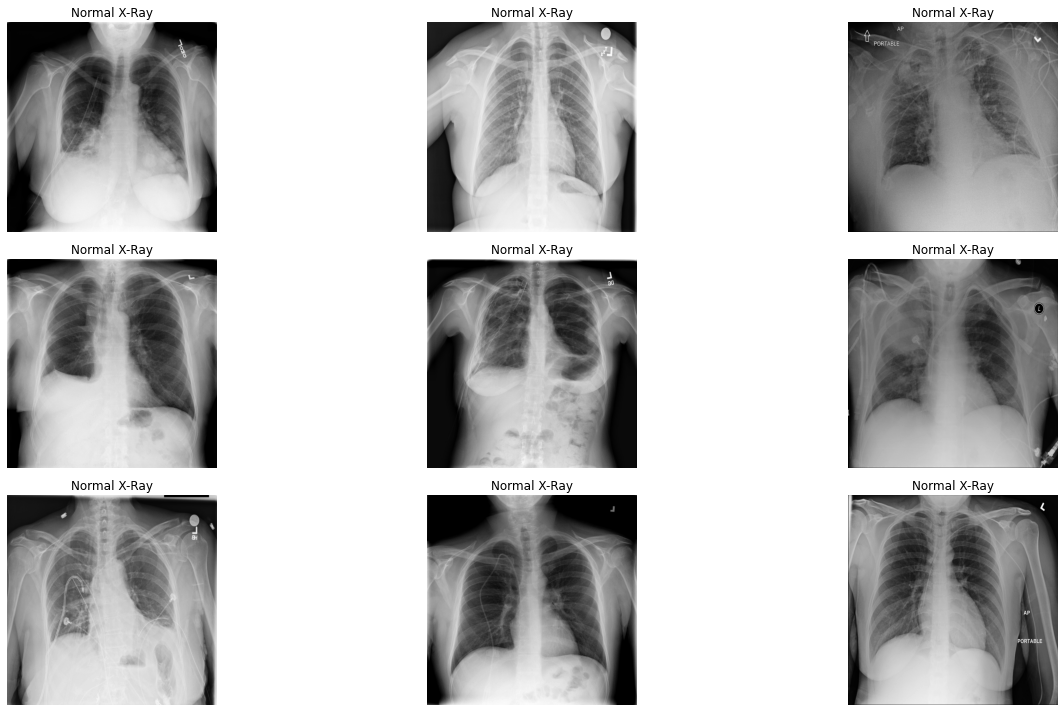

In [26]:
normal = os.listdir(r"C:\Users\Computing\Downloads\data-task1\data-task1\train\no_pneumonia")
normal_dir = r"C:\\Users\Computing\Downloads\data-task1\data-task1\train\no_pneumonia"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Normal X-Ray") 
   
plt.tight_layout()

In [42]:
rescale = 1./255
target_size = (150, 150)
batch_size = 163
class_mode = "categorical"
# class_mode = "binary"


train_datagen = ImageDataGenerator(
    rescale=rescale,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


train_generator = train_datagen.flow_from_directory(
    train,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle=True)


validation_datagen = ImageDataGenerator(rescale=rescale)

validation_generator = validation_datagen.flow_from_directory(
    val,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle = False)


test_datagen = ImageDataGenerator(rescale=rescale)

test_generator = test_datagen.flow_from_directory(
    test,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle = False)

Found 3000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [43]:
from sklearn.utils import class_weight
def get_weight(y):
    class_weight_current =  class_weight.compute_class_weight('balanced', np.unique(y), y)
    return class_weight_current

In [44]:
class_weight = get_weight(train_generator.classes)
class_weight

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


array([0.63613232, 2.3364486 ])

In [45]:
main_model_dir = output_directory + r"models/"
main_log_dir = output_directory + r"logs/"


clear_directory(main_log_dir)
remove_empty_folders(main_model_dir, False)


model_dir = main_model_dir + time.strftime('%Y-%m-%d %H-%M-%S') + "/"
log_dir = main_log_dir + time.strftime('%Y-%m-%d %H-%M-%S')

create_directory(model_dir, remove=True)
create_directory(log_dir, remove=True)

model_file = model_dir + "{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"

NameError: name 'output_directory' is not defined

In [46]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

ValueError: not enough values to unpack (expected 2, got 1)

In [47]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

NameError: name 'cm' is not defined

<Figure size 720x720 with 0 Axes>

In [48]:
from sklearn.metrics import classification_report

y_pred = model.predict(x_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

KeyError: 'pop from an empty set'